### The workflow has the following parts:
* Part 0: set up
* Part I: identify tracking parameters
* Part II: track
* Part III: msds
* Part IV: sanity-checks

This pipeline is largely based on trackpy: <br>

http://soft-matter.github.io/trackpy/v0.4.2/

It was written based on v0.4.2, although it should work with later versions as well.

Before you proceed it is useful to go through the trackpy tutorial.

This pipeline was written for movies of cells that have fluorescent spots within them. These movies have two channels, a phase channel and a fluorescence channel, where the fluorescence channel contains the spots we want to track. However, the pipeline can be adapted to other scenarios, such as tracking spots on the phase images. 

## Part 0: set up

### experimental parameters

Insert below the acquisition framerate, in 1 / seconds, and the pixel-to-micron conversion (typically in microns per pixel).

In [1]:
acquisition_framerate = 1/(0.210) #s (1 / time between frames)
px_to_micron = 0.10748 # microns per pixel

### file location
The tracking pipeline expects a specific folder structure. This goes as follows: <br>
* The movie you are about to track should have a dedicated folder, named after the movie. If, for example, you have a movie called "movie.nd2" that you want to track, you need to have a folder named "movie/". 
* This folder must contain two subfolders. One subfolder should be called "images/" and it should contain all frames of the fluorescent channel of the movie. The other subfolder should be called "phase_images/" and it should contain all frames of the phase channel of the movie. There should be one image file per frame. The default extension is ".tif". <br>
In this pipeline we are tracking fluorescent spots, found in the fluorescence images. The phase images are also necessary for two reasons: 1. to help tune the tracking parameters, by ensuring that you have no spots outside cells 2. to see where the trajectories are located within the cells, which can be interesting and informative.
* All output of this analysis is saved in a third subfolder named 'analysis/', created by this script. 


In the line below insert the path to the movie you will track, up to and containing the movie's dedicated folder.
Note that the path should be specified "in Unix style", i.e. with '/' instead of '\\' between the folder names.<br>


In [2]:
dataset_location = '/Users/sofia/Documents/LEB/PolyP/code/tracking_pipeline_shared/packet/data/210518_0h_bLR1_0001/'

### module import 

Now import all libraries you will need to run the notebook. 
Note that:
* you will need to install trackpy (see link above)
* you may need to install pims: http://soft-matter.github.io/pims/v0.5/ 
* you might have to run the cell below twice in order to get the figures that follow to be interactive. 

In [8]:
import tracking
import pylab
import matplotlib
# %matplotlib notebook  
%matplotlib widget     
import pandas
import numpy
import scipy
import random
import trackpy
import plot_tracking_results
import os
import re

#import plotly
# import bokeh_catplot
# import bokeh.io
# import bokeh.plotting
# bokeh.io.output_notebook()
# from bokeh.io import export_png

Before moving on a few final comments are of note to ensure plots are correctly output. 

Depending on your system settings, you may need to load a different matplotlib backend among the ones listed above (matplotlib notebook, matplotlib widget). 

To check that plots show up as intended by this script, let us make a simple plot below. You should be able to zoom in and out interactively. If not, shut down this notebook and restart it with a different backend from the options included above in lines 4, 5 (notebook or widget). 

In [9]:
pylab.close('test figure')
pylab.figure('test figure')

xs = numpy.arange(-10, 10, 0.1)
ys = xs**3
pylab.plot(xs, ys)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Part I: identify tracking parameters

First, let us get a sense of the intensity range in your images. <br>
To do that, we will load a fluorescent frame and look at the colorbar values that indicate the min and max intensity in the image. <br>
This is a useful first step, because if a specific movie is too dim or too bright you can notice right away. <br>
In the cell below, in line 1 after 'images/', type the filename of the fluorescent frame you want to see; it can be the first frame or the last frame or any frame. 

In [16]:
a = pylab.imread(dataset_location + 'images/2100518_0h_bLR1_0001_t001_c001.tif')
pylab.close('intensity check')
pylab.figure('intensity check')
pylab.imshow(a)
pylab.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Next, look for reasonable spot-identification parameters.  <br>
To do that, pick a frame (it could be the first or the last or any frame you like) and only locate spots on that frame, tweaking parameters until you are satisfied with the result. <br>

In this step, the main parameters to decide on are the diameter and the minmass, where diameter corresponds to the spot size (in pixels, must be an odd number) and minmass corresponds to the minimum integrated spot intensity below which spots will be ignored. For more information see the trackpy tutorial. <br>

To do that you will use the function tracking.test_parameters() below. This function has four main inputs: 
* the dataset location as you specified it in part 0
* the framenumber for the frame on which you want to test the tracking parameters
* the spot diameter
* the spot minmass. <br>
Finally, you might want to change the file extension from '.tiff' to whatever describes your images. <br>

To tune the tracking parameters, you vary the diameter and minmass until you find most bright spots of interest. <br>

It does not much matter, how you end up finding these two parameters, as long as the result makes sense. Here is a suggested method: <br>
* In tracking.test_parameters() first choose phase = True. This will show the found spots overlaid on the phase image. In this step you can make sure that all found spots are inside cells and you can get a sense of their whereabouts within the cell. 
* Then choose superimpose_phase = False and run the cell again, to look at the spots on the fluorescence image. <br>
* To tune the minmass, choose two consecutive values for the minmass - for instance here 110 and 120. The spots found each time will be shown with two different colors, specified as color_a and color_b below. Thus, spots that stand out will have minmass between 110 and 120, so you can zoom in on these to inspect and see if they are real bright spots or indistinguishable from noise. This way you can finalize the choice of minmass. 
* Tuning the diameter is less likely to be necessary, if you have a good sense of the spot size (which you can get by zooming in on a few spots to measure their width). Nonetheless, we will get back to this point shortly.

In [22]:
phase = False # set to True if you want to see the phase image
color_a = '#FFFF00' # yellow
color_b = '#FF00FF' #(magenta)
pylab.close('testing spot parameters')
pylab.figure('testing spot parameters')
c_a = tracking.test_parameters(dataset_location, 0, 9, 2000, color = color_a, superimpose_phase = phase, extension = '*.tif')
c_b = tracking.test_parameters(dataset_location, 0, 9, 4000, color = color_b, superimpose_phase = phase, extension = '*.tif')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

diameter = 9, minmass = 2000, found 530 particles
diameter = 9, minmass = 4000, found 530 particles


Next, let's make sure the chosen diameter is reasonable. <br>
One parameter that can help make this call is the subpixel bias: the distribution of decimal points in the values of the coordinates of the spots found. There is no reason any particular digit should be preferred, so this disitribution should generally be flat (see also the trackpy tutorial). <br>
If the diameter is too small, this can lead to a non-flat subpxel bias. If the diameter is too big, the script might end up merging spots together. So you can optimize by going between the subpixel bias and the image of the found spots above. <br>
Let us look at the subpixel bias for these spots.  

In [23]:
trackpy.subpx_bias(c_a)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128fc8d50>,
      dtype=object)

Once you are satisfied with your choice of diameter and minmass, you can perform a few final inspections. The remaining steps in part I are not necessary but might be useful on occasion.<br>

Some other quantities that can be useful for characterizing the found spots, and potentially filtering them later on, are the localization uncertainty and the eccentricity. To see all possibilities, look at the column titles of the coordinates DataFrame, like so: c.columns. Or take a look at the first few lines of the DataFrame, like so: c.head(). Here c is your DataFrame of choice, for instance it would be c_b from above. <br>

You can inspect your data overall, by making histograms for these values based on the spots we found above. You can also directly annotate spots on the frame you have chosen based on their value. <br>

For example, let us first look at the distribution of localization uncertainty, as calculated by trackpy. <br>
Here the x-axis units are pixels. We will come back to this quantity again later on; for now we just want to see if there is a big distribution, or if most found spots in the frame above have similar localization uncertainty.

In [24]:
c_b.hist('ep', bins=50)
pylab.xlabel('localization uncertainty (px) as calculated by trackpy')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'localization uncertainty (px) as calculated by trackpy')

Next, let us look at the distribution of eccentricity. 

In [25]:
c_b.hist('ecc', bins=50)
pylab.xlabel('eccentriccity, as calculated by trackpy')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'eccentriccity, as calculated by trackpy')

If there are spurious features, such as spots wrongly localized inbetween two real spots, these can often be filtered out based on one of these features such as eccentricity. <br>
To get more direct visual intuition for what the values of these features mean, let us connect these quantities to the spots of the frame already tracked. <br>
To do that we will annotate, on the frame, all found coordinates, then overlay them with all coordinates that satisfy a certain criterion specified in lines 1, 7 below. If there are spurious spots that do not satisfy this criterion, then we have found a way to filter them out.

In [27]:
limit_value = 0.3

pylab.close('eccentricity check')  
pylab.figure('eccentricity check')
images = tracking.load_images(dataset_location + 'images/', extension = '.tif')  # load the images
# red : all spots
trackpy.annotate(c_b, images[0], color = '#FF0000', plot_style={'markersize' : 1}, imshow_style = {'vmin' : 0, 'vmax' : None}) # Here we look at the first frame (images[0]), you can look at any frame you want.
# cyan : only spots with eccentricity < 0.4. 
trackpy.annotate(c_b[c_b.ecc < limit_value], images[0], color = '#00FFFF', plot_style={'markersize' : 1}, imshow_style = {'vmin' : 0, 'vmax' : None})
pylab.text(0, -70, 'o: eccentricity < ' + str(limit_value), color = 'c', fontsize = 11)
pylab.text(0, -15, 'o: all other spots', color = 'r', fontsize = 11)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, -15, 'o: all other spots')

## Part II: track.

Based on the above characterizations you should by now have settled on values for the diameter and minmass, as well as any additional criteria that are relevant for your data based on quantities such as the eccentricity. <br>

Next we will identify all bright spots in all movie frames and then link them into trajectories. <br>

To link, we need to further specify two parameters: 
* the search range: how far a spot can go between frames and still be considered as the same spot
* the memory: the number of frames during which a spot can disappear before it is forgotten. <br>
Finally, we will remove very short trajectories by choosing 
* a stub length: a length (in number of frames) below which trajectories are ignored. For more information, see the trackpy tutorial. <br>

In this tracking pipeline, you can also apply so-called 'selection rules' in the tracking parameters. These are criteria that you wish your bright spots to satisfy. <br>
To specify a selection rule use the format [['quantity', 'relation', value]]. Note the double [[ ]] - this can be a list of lists. Here 
* 'quantity' should be a column of the coordinates DataFrame
* 'relation' is 'greater', 'lesser', 'equal', or 'inbetween' 
* value is a float or integer. If 'relation' is 'inbetween', value is a list of floats or integers with two elements. <br>
For example, to filter by eccentricity such that all features have eccentricity < 0.25, you would type selection_rule = [['ecc','lesser', 0.25]]. <br>
Or, to filter by SNR, such that all features have 2<snr<4, you would type selection_rule = [['snr', 'inbetween', [2, 4]]]. <br>
Or, to filter by both of these criteria, you would type selection_rule = [['snr', 'inbetween', [2, 4]], ['ecc','lesser', 0.25]] <br>
To not use any selection rules, type selection_rule = None. <br>

Insert parameters for tracking:

In [30]:
d = 9 # diameter (pixels)
mm = 4000 # minmass
sr = 4 # search range (pixels)
m = 10 # memory (number of frames)
sl = 10 # stub_length (number of frames)
# selection_rule = [['ep', 'inbetween', [0,sr/2.]], ['snr', 'greater', 1.2], ['size', 'inbetween', [1.2, 1.9]]] 
# selection_rule = None 
selection_rule = [['snr', 'greater', 1.0]] 
selection_rule_in_words = tracking.select_coordinates(None, selection_rule=selection_rule)[1]
directory_now = 'analysis/diameter' + str(d) + '_minmass' + str(mm) + '_percentile65/search_range' + str(sr)+ '_memory' + str(m).zfill(2) + '/'

selection rule:
snr_greater_than_1p0_


Now track. <br>

Two points of convenience:
* When the algorithm is done, it will show you the resulting trajectries on top of your image. If you want to see them on top of the phase image, choose phase = True. 
* If you have already found the spots and you are optimizing their linking parameters, you may not want to wait for the algorithm to track them again and again. Instead, you can save time by reloading the existing coordinates. If you want to do that, set use_existing_coordinates = True, and the script will move straight to linking of the spots you have found previously.


In [31]:
phase = True
use_existing_coordinates = True
coordinates, trajectories, filtered_trajectories, filtered_trajectories_filename = tracking.track(dataset_location, d, mm, sr, m, sl, superimpose_phase=phase, selection_rule=selection_rule, use_if_existing_coordinates = use_existing_coordinates);

Frame 99: 493 trajectories present.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


I found 617 trajectories.


To inspect the trajectories more closely and identify particles that you wish to check more carefully, you can plot the found trajectories below and choose show_particle_id = True, to have their particle id written on the image. <br>
Here I load the phase frames, but you can choose to load the fluorescence frames as well. 

In [32]:
show_particle_id = True
phase_frames = tracking.load_images(dataset_location + 'phase_images/')

pylab.close('trajectories')
pylab.figure('trajectories')
trackpy.plot_traj(filtered_trajectories, superimpose = phase_frames[0], label = show_particle_id)
n = len(set(filtered_trajectories.particle))
# pylab.ylim(705, 605)
# pylab.xlim(190, 290)
pylab.title(str(n) + ' trajectories')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '617 trajectories')

Before we proceed with the analysis of the trajectories, let us do a few sanity-checks. <br>
We will look at the step size distribution and how it compares to the localization uncertainty, as well as to the physical size of the cell and to the related search range that we have imposed. <br>
Below we calculate the step sizes. 

In [33]:
filtered_trajectories = tracking.measure_step_size(filtered_trajectories)

Now let us take a look at the distribution of step sizes. <br>
In the following figure, the blue histogram shows the step sizes and the orange histogram shows the localization uncertainties, as calculated by trackpy. It is always a good idea to measure your localization uncertainty, in addition to this calculation. 

In [37]:
pylab.close('step sizes')
pylab.figure('step sizes')

pylab.hist(filtered_trajectories.previous_step_size * px_to_micron, bins = 100, label = 'step size', alpha = 0.5)
pylab.xlabel('step size (μm)')
pylab.hist(filtered_trajectories.ep * px_to_micron, bins = 25, label = 'localization uncertainty', alpha = 0.5)

pylab.axvline(filtered_trajectories.ep.median() * px_to_micron, color = 'orange', label = 'median loc. uncertainty \n(theoretical): ' + str(round(filtered_trajectories.ep.median() * px_to_micron,3)) + ' μm')
pylab.axvline(sr * px_to_micron, color = 'k', label = 'search range')
pylab.axvline(filtered_trajectories.previous_step_size.median() * px_to_micron, color = '#0699F9', label = 'median step size: ' + str(round(filtered_trajectories.previous_step_size.median() * px_to_micron, 2)) + ' μm')
pylab.legend()
# pylab.xlim(0, 5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


It is also interesting to look at how the step sizes compare to the theoretical localization uncertainty for each step. This is shown below, where we can compare the localization uncertainty of each spot to the size of the step that it traversed between the previous and the current frame. <br>
Points in blue correspond to steps larger than their spot's localization uncertainty, and points in orange correspond to steps smaller than their spot's localization uncertainty - i.e. ill-defined steps. 

0.2% of steps are too small compared to the localization uncertainty (as calculated by trackpy).


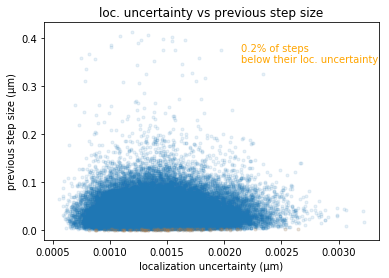

In [16]:
pylab.close('loc. uncertainty vs previous step size')
pylab.figure('loc. uncertainty vs previous step size')
pylab.title('loc. uncertainty vs previous step size')

pylab.plot(filtered_trajectories.ep * px_to_micron, filtered_trajectories.previous_step_size * px_to_micron, '.', alpha = 0.1)
#pylab.plot(numpy.arange(0, filtered_trajectories.ep.max() * px_to_micron, 0.01), numpy.arange(0, filtered_trajectories.ep.max() * px_to_micron, 0.01), color = 'r', label = 'ep = step size')
unc_larger_than_step = filtered_trajectories[filtered_trajectories.ep > filtered_trajectories.previous_step_size]
pylab.plot(unc_larger_than_step.ep * px_to_micron, unc_larger_than_step.previous_step_size * px_to_micron, '.', alpha = 0.1)
#pylab.legend(loc = 1, framealpha = 0)

problematic = 100 * len(unc_larger_than_step) / len(filtered_trajectories)
problematic = str(round(problematic,1))
print(str(problematic) + '% of steps are too small compared to the localization uncertainty (as calculated by trackpy).')
pylab.text(0.02 * px_to_micron, 0.35, str(problematic) + '% of steps\nbelow their loc. uncertainty', color = 'orange')
pylab.xlabel('localization uncertainty (μm)')
pylab.ylabel('previous step size (μm)')
pylab.savefig(dataset_location + directory_now + 'previous_step_size-vs-loc_uncertainty.png', bbox_inches = 'tight')

Finally, it is a good idea to make a few movies of individual trajectories, to make sure that you have chosen reasonable parameters. <br>
In the kernel below you can generate a series of images with a small field of view centered around a particle of your choice, with its trajectory drawn in real time. You can speficy the id of this particle, or a list of ids, in line 1. <br>
Again, you can also choose whether to draw the trajectories on the phase image, by choosing phase = True. 
The frames of these movies will be saved in the "analysis/" folder that has been created within the main movie folder.

In [38]:
particle_ids = [373] # list of particle ids 
phase = True
pylab.ion()
trajectory_specifier = 'stub_length' + str(sl).zfill(3) + '_' + selection_rule_in_words
print(trajectory_specifier)
for i in particle_ids:   #  you can also generate a random list of numbers from the set of existing ids, that you can get from list(set(filtered_trajectories.particle))
    tracking.trajectory_movie(dataset_location, directory_now, trajectory_specifier, particle_id = i, superimpose_phase = phase)

stub_length010_snr_greater_than_1p0_
I have chosen this file: 
filtered_trajectories_stub_length010_snr_greater_than_1p0_.pkl
/Users/sofia/Documents/LEB/PolyP/code/tracking_pipeline_shared/packet/data/210518_0h_bLR1_0001/analysis/diameter9_minmass4000_percentile65/search_range4_memory10/filtered_trajectories_stub_length010_snr_greater_than_1p0_.pkl
I have chosen particle 373.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Part III: from tracks to msd.
First, calculate the individual msds (imsds) and the ensemble msd (emsd). Then, from the imsds obtain values for the diffusion coefficient and for the scaling exponent.

In tracking.calculate_msds() you can specify if you wish to ignore frames beyond a certain framenumber, using "ff" in line 2 (for "final frame"). 


In [39]:
# recalculate = True
ff = None # final frame 
imsds = {}
emsd = {}

imsds['all'], emsd['all'], msd_label =  tracking.calculate_msds(dataset_location + directory_now, sl, px_to_micron = px_to_micron, fps = acquisition_framerate, trajectory_type = 'filtered', selection_rule=selection_rule, final_frame=None, recalculate_msds=True)

selection rule:
snr_greater_than_1p0_
Loaded trajectories: /Users/sofia/Documents/LEB/PolyP/code/tracking_pipeline_shared/packet/data/210518_0h_bLR1_0001/analysis/diameter9_minmass4000_percentile65/search_range4_memory10/filtered_trajectories_stub_length010_snr_greater_than_1p0_.pkl
Final frame: 99.
I am including up to frame 099.
no imsds saved for these parameters
no emsd saved  for these parameters


Let's look at the msds! <br>
To make a linear plot, in what follows choose ll = False (for "not log log"). 

In [40]:
ll = True
pylab.close('imsds')
pylab.figure('imsds')
pylab.xlabel('time lag (s)')
pylab.ylabel('msd (μm^2)')

pylab.close('emsd')
pylab.figure('emsd')
pylab.xlabel('time lag (s)')
pylab.ylabel('msd (μm^2)')

plot_tracking_results.plot_msds(imsds = imsds['all'], emsd = emsd['all'], loglog = ll, color = '#0000FF', alpha_imsd = 0.02, emsd_label = None, interactive_plot = True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Before fitting these curves to obtain values for the diffusion coefficient and scaling exponent, let us take a look at a couple of basic features. <br>
First - how many datapoints per time lag? <br>
Second - how many points do trajectories have?

In [41]:
pylab.close('number of measurements')
pylab.figure('number of measurements')
pylab.plot(emsd['all'].index, emsd['all'].N, '.')
pylab.ylabel('number of datapoints')
pylab.xlabel('time lag (s)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'time lag (s)')

In [42]:
trajectory_points = []
for i in set(filtered_trajectories.particle):
    #npoints = len()
    trajectory_points.append(len(filtered_trajectories[filtered_trajectories.particle==i]))

pylab.close('number of points in the trajetories')    
pylab.figure('number of points in the trajetories')
pylab.hist(trajectory_points, bins = 10)
pylab.xlabel('number of points')
pylab.ylabel('occurences')
pylab.title('total number of trajectories: ' + str(len(set(filtered_trajectories.particle))) )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'total number of trajectories: 617')

### Congratulations! You have made it from a raw movie of moving spots, to the msds.

## Part IV: sanity-checks.

It is time to estimate the effects of possible sources of error in the final result. <br>
The main two sources of error to watch out for are static and dynamic error. <br>
There is also an error associated with the finite number of measurements per time lag; however this is already included in the form of error bars on the msd. These errorbars represent the statistical error associated with the total number of independent measurements per time lag; this number is calculated by trackpy, which, in turn, is based on Qian et al, Biophysical journal 60.4 (1991): 910.

### static error
The main source of static error in our case is the signal-to-noise ratio. <br>
To see if our results are sensitive to the signal-to-noise ratio, in what follows we will investigate whether the msd of the brighter spots is different from the msd of the darker spots. Here we calculate the signal-to-noise ratio with trackpy, which in turn is based on the method described in Savin and Doyle. <br>

First, let us take a look at the signal-to-noise ratio. <br>
If the movie has fiducials that you have not filtered out in tracking, they will appear right away as occurrences with exceptionally high SNR. In that case you can use the histogram below to estimate the fiducial SNR and block it out for this sanity check, as will be explained below. 

In [ ]:
pylab.close('SNR, whole movie')
pylab.figure('SNR, whole movie')
pylab.title('SNR, whole movie')

#t_now = filtered_trajectories[filtered_trajectories.snr < 50]
t_now = filtered_trajectories
pylab.hist(t_now.snr, bins = 30, color = '#0000FF', edgecolor = '#000000');
pylab.xlabel('SNR')
pylab.ylabel('occurences')

Let us also take a look at how the SNR of the movie changes with time, i.e. how significant bleaching is. 
You can specify the final frame in line 1 below.

In [ ]:
final_frame = 99

pylab.close('SNR, beginning and end')
pylab.figure('SNR, beginning and end')
pylab.title('SNR, beginning and end')

t_now = filtered_trajectories[filtered_trajectories.snr < 50]
pylab.hist(t_now[t_now.frame==0].snr, bins = 30, color = '#0000FF', edgecolor = '#000000', alpha = 0.5, label= 'frame   0');
pylab.hist(t_now[t_now.frame==final_frame].snr, bins = 30, color = '#00AAFF', edgecolor = '#000000', alpha = 0.5, label = 'frame ' + str(final_frame));
pylab.legend()
pylab.xlabel('SNR')
pylab.ylabel('occurences')

Now bin the SNR into 3 bins and calculate the msd per bin. <br>
This step can be a little tricky. If you simply divide the spots into bins of equal width in snr, you will very likely end up with a very different number of trajectories in each bin. This is because, as you can see in the histograms of SNR above, most spots have a certain SNR. So it may be that there are as many trajectories in one central SNR bin as there are in several SNR bins towards the edges. <br>

For this reason here we will choose the SNR bins based on quantiles. This will allow us to pick bins that always contain the same number of fluorescent points. Note that still, this will not necessarily lead to the same number of trajectories in each bin; but it will help. 

You can choose the number of quantiles in line 1 of the following cell.

In [ ]:
number_of_quantiles = 3.
quantiles = []

for i in numpy.arange(0, 1.0, 1./(number_of_quantiles)):
    quantiles.append(t_now.quantile(i, 0).snr)

quantiles.append(t_now.snr.max())
print('For ' + str(int(number_of_quantiles)) + ' quantiles, use the following bin limits: ')
print(quantiles)

In the cell below you can filter out fiducials, if there are any. <br>
To do that, set the value for max_snr to be less than the SNR value of these spots, in line 1 below.

In [ ]:
max_snr = 50

pylab.close('SNR, whole movie, ' + str(int(number_of_quantiles)) + ' bins')
pylab.figure('SNR, whole movie, ' + str(int(number_of_quantiles)) + ' bins')
pylab.title('SNR, whole movie, ' + str(int(number_of_quantiles)) + ' bins')

t_now = filtered_trajectories[filtered_trajectories.snr < max_snr]  # in case there are fiducials with SNR ~ max_snr

pylab.hist(t_now.snr, bins = 30, color = '#0000FF', edgecolor = '#000000');
pylab.xlabel('SNR')
pylab.ylabel('occurences')
for i in quantiles:
    pylab.axvline(i, color='#000000', linestyle = '--')

Now that we have decided how to divide the spots according to their SNR, we can make trajectories that only contain points within one SNR bin. <br>
To achieve this, we track the movie again once per SNR bin and in each case we only retain points with SNR within this bin; then we link those points. In this way we ensure that each new set of trajectories - one set per SNR bin - only includes points within the specified SNR range. <br>
Localization uncertainty can appear as 'fake mobility'. Therefore, if static error is significant for any of these SNR bins, the resulting msds will be different: the msd corresponding to loci with lower SNR will appear higher than the msd corresponding to loci with higher SNR.  <br>
If static error is not significant, then the resulting msds should be equivalent and independent of SNR. 

As before, you can specify whether you want to see the tracked particles over the phase image by specifying "phase = True".

In [ ]:
t = {}  # initializing a dictionary of trajectories, where each entry will correspond to one SNR bin

In [ ]:
phase = True
for i in numpy.arange(len(quantiles)-1):
    print(i)
    selection_rule = [['snr', 'inbetween', [quantiles[i], quantiles[i+1]]]]
    print(selection_rule)
    criterion = selection_rule[0][0] + '-' + selection_rule[0][1] + '-' + str(round(selection_rule[0][2][0],2)) + '-' + str(round(selection_rule[0][2][1],2))
    t[criterion] = tracking.track(dataset_location, d, mm, sr, m, sl, superimpose_phase=phase, selection_rule=selection_rule, plot = False, use_if_existing_coordinates=False)[2];
    
t['all'] =  tracking.track(dataset_location, d, mm, sr, m, sl, superimpose_phase=phase, selection_rule=None, plot = False, use_if_existing_coordinates=False)[2];
# t['all'] = filtered_trajectories

Time to see if the msds from these subsets of spots differ. First we will calculate them, then we will plot them. <br>
You can again specify the final frame of this calculation in line 1 below.

In [ ]:
ff = None

imsds = {}
emsd = {}

for i in t.keys():
    print(i)
    if i == 'all':
        selection_rule = None
        print('selection rule:')
        print(selection_rule)
    else:
        quantity = i.split('-')[0]
        relation = i.split('-')[1]
        values =  [float(x) for x in list(i.split('-')[2:4])]
        print('selection rule:')
        selection_rule = [[quantity, relation, values]]
        print(selection_rule)
    imsds[i], emsd[i], msd_label = tracking.calculate_msds(dataset_location + directory_now, sl, px_to_micron = px_to_micron, fps = acquisition_framerate, trajectory_type = 'filtered', selection_rule=selection_rule, final_frame = ff, recalculate_msds=True);
   

In the following plots, choose ll = True in line 1 if you want the log-log plots.

In [ ]:
ll = True

color = {}
c = []
labels = []

for i in numpy.linspace(255, 65280, 7):
    i = int(i)
    j = "#%06X" %(i, )
    c.append(j)
   
 
for i, j in enumerate(imsds.keys()):    
    color[j] = c[i]

pylab.close('imsds, different SNR bins')
pylab.figure('imsds, different SNR bins', figsize = (8,8))

pylab.close('emsd, different SNR bins')
pylab.figure('emsd, different SNR bins')

for i in imsds.keys():
    plot_tracking_results.plot_msds(imsds = imsds[i], emsd = emsd[i], loglog = ll, color = color[i], symbol = '.', alpha_imsd = 0.1, alpha_emsd = 1.0, linewidth = 2, legend_content = i, legend_location=None, emsd_label=i, interactive_plot = True, new_imsd_figure=True, new_emsd_figure=True, plot_imsds=True, imsd_title = 'imsds, different SNR bins', emsd_title = 'emsd, different SNR bins', edgecolor=None);
    #print(i)
    j = i + '\n' + str(len(imsds[i].columns)) + ' particles'
    labels.append(j)
pylab.legend(labels, loc = 2)
#pylab.ylim(0, 0.06)
pylab.axvline(emsd[i].index.max()/2., color = '#000000', linestyle = '--')


In this case, the msd seems unaltered by the SNR of the spots that participated in its calculation, within error. <br>
The vertical line marks half of the total movie duration. It is common practice to give more gravity to the msd up to this time point, because beyond that you no longer have more than one completely independent set of displacement measurements. <br>

And this brings us to the end of this tracking pipeline. 

### The following two sections are under editing. We might not keep them. Followup on this by June 16th. 

### dynamic error - might be removed, we have not needed it
The formula we will use to include dynamic error in the msd comes from Savin & Doyle, Biophysical Journal 88, 623--638 (2005). It is a formula for the measured msd in the presence of dynamic error. As such, it depends not only on the diffusion coefficient and scaling exponent, but also on the exposure time. In this implementation we are also including a parameter for a constant offset, as this is often observed and also expected from static error. <br>

First, let us try to fit the data to this expression. Note that this expression is a complex polynomial and the fits do not converge easily. Therefore, let us use the results from the fit above as an initial guess.

In [ ]:
exposure_time = 0.03 # seconds

current_emsd_key = 'all'
current_emsd_dataframe = emsd[current_emsd_key]
#current_emsd_dataframe = current_emsd_dataframe.iloc[20:150,:]  # here you can choose to fit to a part of the emsd curve

linear_fit_with_derror, linear_fit_with_derror_covariance = scipy.optimize.curve_fit(tracking.msd_with_dynamic_error, current_emsd_dataframe.index, current_emsd_dataframe.msd,
                                                                                     p0 = numpy.array([linear_fit[0], linear_fit[1], linear_fit[2], exposure_time]), 
                                                                                    # sigma = emsd[k].error_finiteness
                                                                                    )

print('Fit results with dynamic error:\nDcoeff = %f +/- %f um^2/s\nexponent = %f +/- %f\noffset = %f+/- %f  um^2\nexposure time = %f.' %(linear_fit_with_derror[0], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_with_derror_covariance))[0], 
                                                                                              linear_fit_with_derror[1], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_with_derror_covariance))[1], 
                                                                                              linear_fit_with_derror[2], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_with_derror_covariance))[2],
                                                                                              linear_fit_with_derror[3]
                                                                                          ))

print('\nFit results without dynamic error:\nDcoeff = %f +/- %f um^2/s\nexponent = %f +/- %f\noffset = %f +/- %f um^2.' %(linear_fit[0], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[0], 
                                                                                              linear_fit[1], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[1], 
                                                                                              linear_fit[2], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[2]
                                                                                             ))

pylab.close('fit to subdiffusive msd with dynamic error, and with constant offset');
pylab.figure('fit to subdiffusive msd with dynamic error, and with constant offset', figsize = (5,5));
pylab.title('fit to subdiffusive msd with dynamic error,\nand with constant offset');

pylab.errorbar(current_emsd_dataframe.index, current_emsd_dataframe.msd, yerr = current_emsd_dataframe.error_finiteness, xerr = None, fmt = '.', alpha = 1, color = '#0000FF', label = 'data')
pylab.plot(current_emsd_dataframe.index, tracking.msd_general_diffusion(current_emsd_dataframe.index, Dcoeff = linear_fit[0], exponent = linear_fit[1], offset=linear_fit[2]), 'c-', linewidth = 2, label = 'fit to msd')
pylab.plot(current_emsd_dataframe.index, tracking.msd_with_dynamic_error(current_emsd_dataframe.index, Dcoeff = linear_fit_with_derror[0], exponent = linear_fit_with_derror[1], offset=linear_fit_with_derror[2]), '#FFAA00', linestyle = '--', linewidth = 2, label = 'fit to msd with dynamic error')

pylab.legend(loc=2, frameon = False)
pylab.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]');
pylab.xlabel('time lag (s)');

pylab.text(12, 0.015, 'Dcoeff = %f +/- %f um^2/s\nexponent = %f +/- %f\noffset = %f +/- %f um^2' %(linear_fit_with_derror[0], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_with_derror_covariance))[0], 
                                                                                              numpy.round(linear_fit_with_derror[1], 3), 
                                                                                              numpy.round(numpy.sqrt(numpy.diag(linear_fit_with_derror_covariance))[1], 3), 
                                                                                              linear_fit_with_derror[2], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_with_derror_covariance))[2]
                                                                                             ), color = '#FFAA00')

pylab.text(12, 0.001, 'Dcoeff = %f +/- %f um^2/s\nexponent = %f +/- %f\noffset = %f +/- %f um^2' %(linear_fit[0], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[0], 
                                                                                              numpy.round(linear_fit[1], 3), 
                                                                                              numpy.round(numpy.sqrt(numpy.diag(linear_fit_covariance))[1], 3), 
                                                                                              linear_fit[2], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[2]
                                                                                             ), color = 'c')
#pylab.savefig('200729_bLR32_6h_30msExp_200msLag_013_reg_7d_400mm_emsd_with_error_searchrange20')

If dynamic error is not significant, both fits should look reasonable and the fit results should not differ substantially whether you include dynamic error or not. However, the uncertainties from the fit to the equation *with* dynamic error are often infinite. This is probably due to the fact that the equation is difficult to fit. <br> <br>
If you cannot put error bars on the fit to the msd with dynamic error, and if the values are similar and either fit looks reasonable, it is recommended to take the values from the fit to the pure msd. It is better to have an error esimate in your results than not. 

### <font color='orange'> Note: the part for obtaining the values for D, α will be updated.

Now let's fit to these curves to extract a diffusion coefficient, D, and a scaling exponent, α. <br>
Note that in the linear fit to the emsd, performed below, there is an option to specify the max timelag you wish to use. 
Here we use linear-linear plots and the corresponding expression for subdiffision: msd(t) = 4Dt^α + C. <br>
The offset C is often observed and also expected from static error. 

In [ ]:
current_emsd_key = 'all' # later on you will have other emsds, but here we are looking at all trajectories without discrimination
current_emsd_dataframe = emsd[current_emsd_key]
#current_emsd_dataframe = current_emsd_dataframe.iloc[20:150,:]  # here you can choose to only fit a part of the msd curve

linear_fit, linear_fit_covariance = scipy.optimize.curve_fit(tracking.msd_general_diffusion, current_emsd_dataframe.index, current_emsd_dataframe.msd)
#linear_fit_s, linear_fit_s_covariance = scipy.optimize.curve_fit(tracking.msd_general_diffusion, current_emsd_dataframe.index, current_emsd_dataframe.msd, sigma=current_emsd_dataframe.error_finiteness)
print('Fit results:\nDcoeff = %f +/- %f um^2/s\nexponent = %f +/- %f\noffset = %f +/- %f um^2.' %(linear_fit[0], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[0], 
                                                                                              linear_fit[1], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[1], 
                                                                                              linear_fit[2], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[2]
                                                                                             ))

#print('Fit results with uncertainties fitted: Dcoeff = %f um^2/s, exponent = %f, offset = %f.' %(linear_fit_s[0], 
#                                                                                              #numpy.sqrt(numpy.diag(linear_fit[1][0])), 
#                                                                                              linear_fit_s[1], 
#                                                                                              #numpy.sqrt(numpy.diag(linear_fit[1][1])), 
#                                                                                              linear_fit_s[2], 
#                                                                                              #numpy.sqrt(numpy.diag(linear_fit[1][2]))
#                                                                                             ))

pylab.close('emsd, calculated from ' + current_emsd_key + ', fit to subdiffusive msd with constant offset')
pylab.figure('emsd, calculated from ' + current_emsd_key + ', fit to subdiffusive msd with constant offset')
pylab.title('emsd, calculated from ' + current_emsd_key + '\nfit to subdiffusive msd, with constant offset')
pylab.errorbar(current_emsd_dataframe.index, current_emsd_dataframe.msd, yerr = current_emsd_dataframe.error_finiteness, xerr = None, fmt = '.', alpha = 1, color = '#0000FF')
pylab.plot(current_emsd_dataframe.index, tracking.msd_general_diffusion(current_emsd_dataframe.index, Dcoeff = linear_fit[0], exponent = linear_fit[1], offset=linear_fit[2]), '#0099FF', linewidth = 2, zorder = 10)
#pylab.plot(current_emsd_dataframe.index, tracking.msd_general_diffusion(current_emsd_dataframe.index, Dcoeff = linear_fit_s[0], exponent = linear_fit_s[1], offset=linear_fit_s[2]), 'r-', linewidth = 2)
pylab.xlabel('time lag (s)')
pylab.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
pylab.ylim(0, None)
pylab.text(25, 0.003, 'Dcoeff = %f +/- %f um^2/s \nexponent = %f +/- %f \noffset = %f +/- %f um^2' %(linear_fit[0], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[0], 
                                                                                              numpy.round(linear_fit[1], 3), 
                                                                                              numpy.round(numpy.sqrt(numpy.diag(linear_fit_covariance))[1], 3), 
                                                                                              linear_fit[2], 
                                                                                              numpy.sqrt(numpy.diag(linear_fit_covariance))[2]
                                                                                              ), color = '#0099FF')
#pylab.text(25, 0.01, 'Dcoeff = %f +/- %f um^2/s \nexponent = %f +/- %f \noffset = %f +/- %f um^2' %(linear_fit_s[0], 
#                                                                                               numpy.sqrt(numpy.diag(linear_fit_s_covariance))[0], 
#                                                                                               numpy.round(linear_fit[1], 3), 
#                                                                                               numpy.round(numpy.sqrt(numpy.diag(linear_fit_s_covariance))[1], 3), 
#                                                                                               linear_fit[2], 
#                                                                                               numpy.sqrt(numpy.diag(linear_fit_s_covariance))[2]
#                                                                                               ), color = 'r')
pylab.savefig(dataset_location + directory_now + 'fit_to_emsd-' + current_emsd_key + '.png', bbox_inches = 'tight')